In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from utils import *
import warnings


sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

data_path = "Data\\BL_M_combined.csv"

target_column = 'pain improvement percentage' # We will use this column to define treatment success

In [3]:
# Load the data
data_M = get_data(data_path)

# Get column names
dem_clinic_features, left, right, all_features = get_columns_names()

In [4]:
random_forest_scores = []
feature_importance_dict_rf = {key: 0.0 for key in all_features}
feature_importance_dict_shap = {key: 0.0 for key in all_features}
random_seeds = np.arange(0, 100)

# Data partitioning
data_main = data_M
data_intermediate = data_main[(data_main[target_column] > 0) & (data_main[target_column] < 0.25)]  # Filter intermediate target values
data_main = data_main[(data_main[target_column] <= 0) | (data_main[target_column] >= 0.25)]  # Filter remaining values

# Loop over seeds for reproducibility
for seed in random_seeds:
    print(f"Starting seed {seed}")
    
    # Shuffle and split data into training and testing sets (75% train, 25% test)
    shuffled_data = data_main.sample(frac=1, random_state=seed)
    num_rows_train = int(0.75 * len(shuffled_data))
    
    # Split into train and test datasets
    train_data = shuffled_data.head(num_rows_train)
    test_data = shuffled_data.tail(len(shuffled_data) - num_rows_train)

    # Extract features
    left_features, _ = get_feature_importance(train_data.copy(), target_column, left, 10)
    right_features, _ = get_feature_importance(train_data.copy(), target_column, right, 10)
    chemical_features = np.concatenate((left_features, right_features))
    
    demographic_features, _ = get_feature_importance(train_data.copy(), target_column, dem_clinic_features, len(dem_clinic_features) - 1)
    all_selected_features = np.concatenate((chemical_features, demographic_features, np.array([target_column])))

    # Filter train, test, and intermediate datasets based on selected features
    train_data = train_data[all_selected_features].dropna()
    test_data = test_data[all_selected_features].dropna()
    intermediate_data = data_intermediate[all_selected_features].dropna()

    # Get feature importance for training data
    selected_features, importance_values = get_feature_importance(train_data.copy(), target_column, all_selected_features, len(all_selected_features) - 1)
    for feature, importance in zip(selected_features, importance_values):
        feature_importance_dict_rf[feature] += importance  # Aggregate feature importance

    # Prepare train and test sets
    X_train = train_data.drop(target_column, axis=1)
    y_train = train_data[[target_column]]
    X_test = test_data.drop(target_column, axis=1)
    y_test = test_data[[target_column]]

    # Train and evaluate RandomForest for demographic + clinical data
    demographic_test_auc = \
        tune_randomforest_classifier(
            intermediate_data[demographic_features + [target_column]].copy(),
            X_train[demographic_features], X_test[demographic_features],
            y_train.copy(), y_test.copy(),
            feature_importance_dict_shap, chemical=False, target=target_column
        )

    # Train and evaluate RandomForest for demographic + clinical + chemical data
    chemical_auc_test = \
        tune_randomforest_classifier(
            intermediate_data.copy(), X_train, X_test,
            y_train.copy(), y_test.copy(),
            feature_importance_dict_shap, chemical=True, target=target_column
        )

    # Store results
    random_forest_scores.append([demographic_test_auc, chemical_auc_test])

Starting seed 0
Starting seed 1
Starting seed 2
Starting seed 3
Starting seed 4
Starting seed 5
Starting seed 6
Starting seed 7
Starting seed 8
Starting seed 9
Starting seed 10
Starting seed 11
Starting seed 12
Starting seed 13
Starting seed 14
Starting seed 15
Starting seed 16
Starting seed 17
Starting seed 18
Starting seed 19
Starting seed 20
Starting seed 21
Starting seed 22
Starting seed 23
Starting seed 24
Starting seed 25
Starting seed 26
Starting seed 27
Starting seed 28
Starting seed 29
Starting seed 30
Starting seed 31
Starting seed 32
Starting seed 33
Starting seed 34
Starting seed 35
Starting seed 36
Starting seed 37
Starting seed 38
Starting seed 39
Starting seed 40
Starting seed 41
Starting seed 42
Starting seed 43
Starting seed 44
Starting seed 45
Starting seed 46
Starting seed 47
Starting seed 48
Starting seed 49
Starting seed 50
Starting seed 51
Starting seed 52
Starting seed 53
Starting seed 54
Starting seed 55
Starting seed 56
Starting seed 57
Starting seed 58
Startin

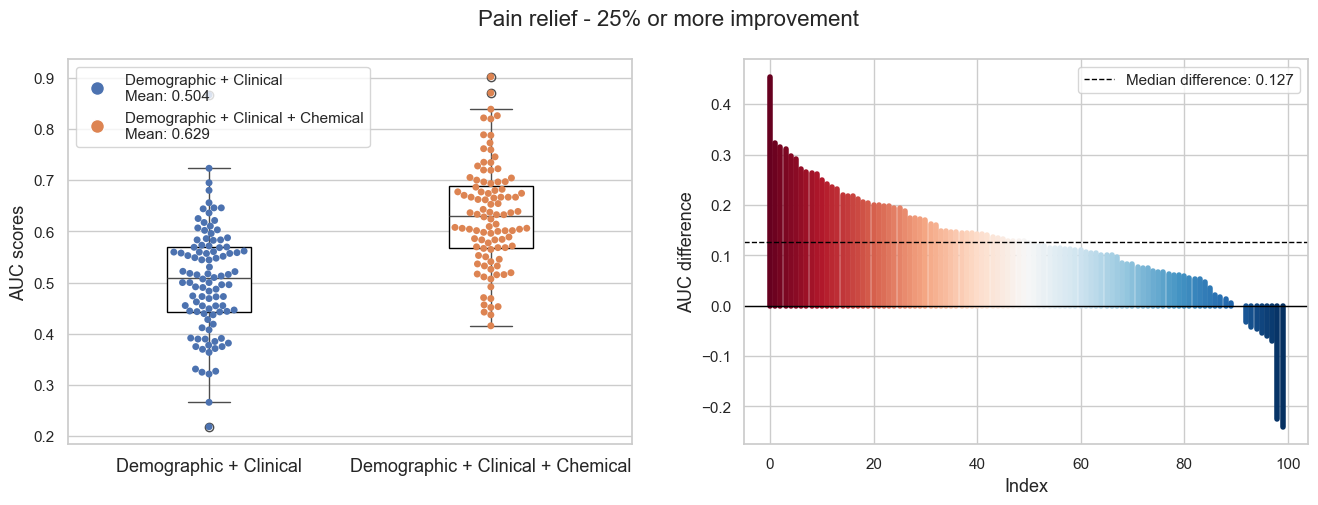

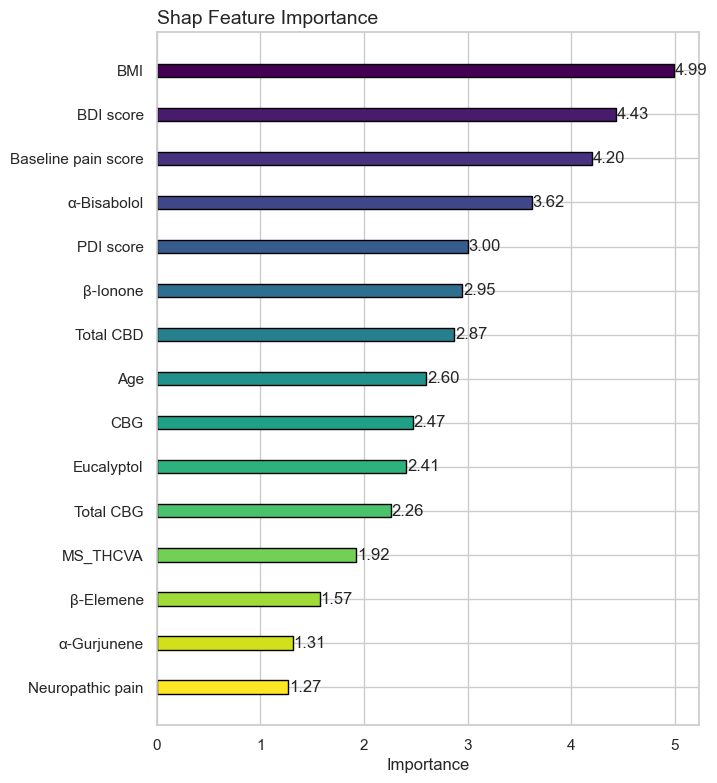

In [5]:
# Convert lists to arrays for plotting
random_forest_scores_array = np.array(random_forest_scores)

# Plotting waterfall beeswarm plots
main_plot_title = "Pain relief - 25% or more improvement"
plot_waterfall_and_beeswarm(
    random_forest_scores_array,
    [random_forest_scores_array[:, 0], random_forest_scores_array[:, 1]],
    '', '',
    ['Demographic + Clinical', 'Demographic + Clinical + Chemical'],
    main_plot_title
)

# Plot top SHAP features
plot_top_features(feature_importance_dict_shap, 15, 'Shap Feature Importance')

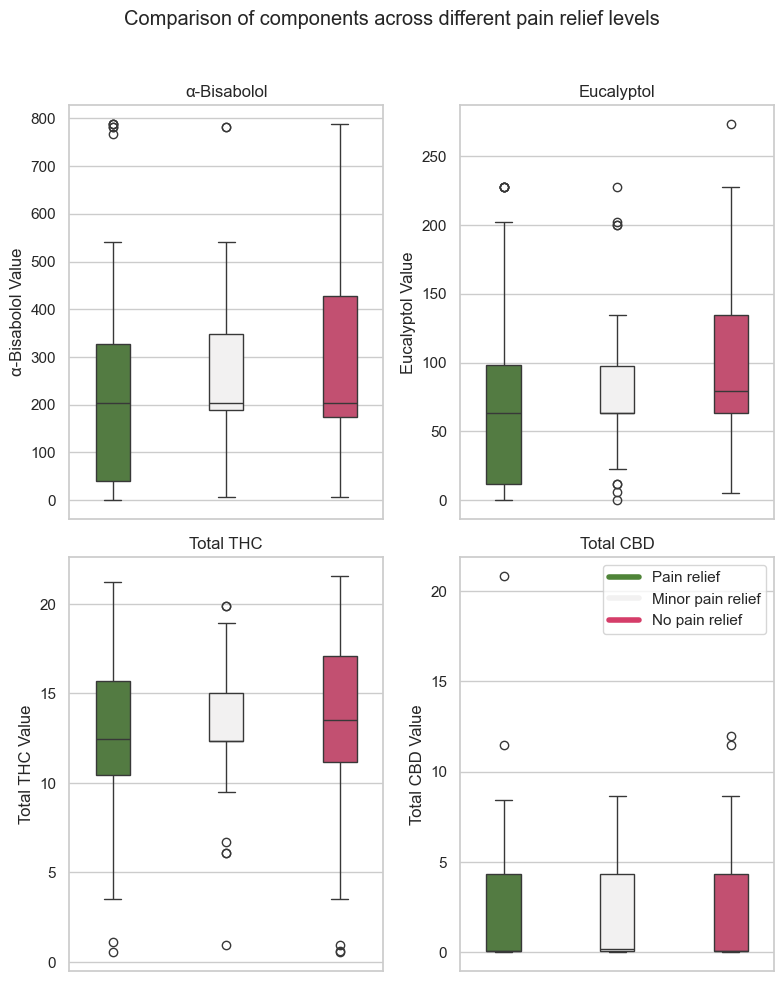

In [6]:
data = get_data(data_path)
target = 'pain improvement percentage'
data[target] = data[target].apply(transform_column_to3)

columns_list = ['α-Bisabolol', 'Eucalyptol', "Total THC", "Total CBD"]

desired_order = ['Pain relief', 'Minor pain relief', 'No pain relief']

desired_colors = sns.diverging_palette(120, 0, n=len(desired_order), as_cmap=False).as_hex()

# Create a 2x2 layout for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10))
axes = axes.flatten()

# Iterate through each feature and create a beeswarm plot on a separate subplot
for i, feature in enumerate(columns_list):
    plot_beeswarm_for_feature(data, feature, axes[i], desired_order, desired_colors, target)


fig.suptitle("Comparison of components across different pain relief levels")

# Create a legend outside the subplots
custom_lines = [Line2D([0], [0], color=desired_colors[i], lw=4) for i in range(len(desired_order))]
plt.legend(custom_lines, desired_order, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig('fig3.pdf', format='pdf', bbox_inches='tight')